# Read Results

This notebook plots the results and creates the Latex tables for all ablation experiments.

Therefore, this notebook uses the result logs from `NUM_RUNS` runs stored in `data/results/results_run_[run number]`. The result logs produced during all our experiments (over 3 runs) are included for completeness.

In [31]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp

Settings and definition of constants (usually not required to adjust):

In [32]:
NUM_RUNS = 3
DATA_PATH = '../data'
RESULTS_PATH = osp.join(DATA_PATH, 'results')
TEX_PATH = osp.join(DATA_PATH, 'tex')

model_2_name = {
    'literaledistmult': 'LiteralE$_{DistMult}$',
    'literalecomplex': 'LiteralE$_{ComplEx}$',
    'kbln': 'KBLN',
    'multitask': 'MTKGNN',
    'transea': 'TransEA'
}

dataset_2_name = {
    'fb15k-237': 'FB15k-237',
    'yago3-10': 'YAGO3-10',
    'litwd48k': 'LitWD48k'
}

Collect all result log files that will be used for the plots and tables:

In [34]:
def extract_test_scores(result_file_path):
    MRR = None
    MR = None
    Hits_at_10 = None
    Hits_at_3 = None
    Hits_at_1 = None

    with open(result_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'transea' in result_file_path.lower():
                if line.startswith('Test MR'):
                    MR, MRR, Hits_at_10, Hits_at_3, Hits_at_1 = [float(score.replace(': ', '')) for score in re.findall(": \d.\d.\d*", line)]

            else:
                if 'Mean reciprocal rank:' in line:
                    MRR = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Mean rank:' in line:
                    MR = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Hits @10:' in line:
                    Hits_at_10 = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Hits @3:' in line:
                    Hits_at_3 = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))
                if 'Hits @1:' in line:
                    Hits_at_1 = float(re.findall(": \d.\d*", line)[0].replace(': ', ''))

    return {'MRR': MRR, 'MR': MR, 'Hits@10': Hits_at_10, 'Hits@3': Hits_at_3, 'Hits@1': Hits_at_1}


result_files = {}

for i in range(1, NUM_RUNS + 1):

    if not os.path.exists(osp.join(RESULTS_PATH, f'results_run_{i}')):
        print(f'Run {i} does not exist. No directory:', osp.join(RESULTS_PATH, f'results_run_{i}'))
    else:
        print('Loading result logs from:', osp.join(RESULTS_PATH, f'results_run_{i}'))
        for result_file in os.listdir(osp.join(RESULTS_PATH, f'results_run_{i}')):
            if result_file.startswith('slurm_'):
                if result_file not in result_files:
                    result_files[result_file] = []
                result_files[result_file].append(extract_test_scores(osp.join(RESULTS_PATH, f'results_run_{i}/{result_file}')))

Loading result logs from: ../data/results/results_run_1
Loading result logs from: ../data/results/results_run_2
Loading result logs from: ../data/results/results_run_3


# Plots
### Numerical feature ablation: original literal feature vs. random features -> org_vs_rand_fig.pdf


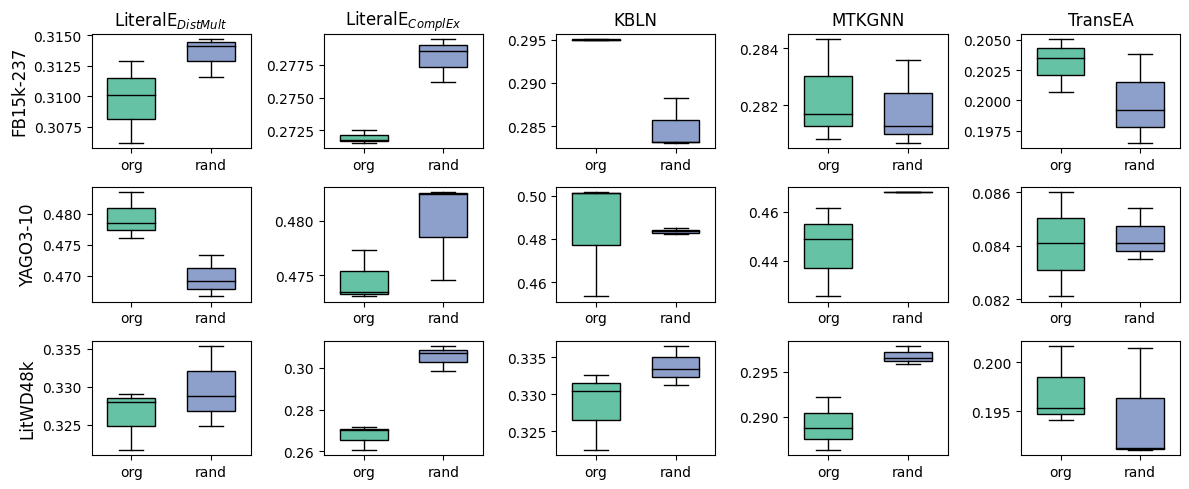

In [36]:
fig, axs = plt.subplots(3, 5, figsize=(12, 5))

color_a = '#66c2a5' #'#7fc97f' #'#b3e2cd'
color_b = '#8da0cb' # '#fdc086' # '#cbd5e8'


medianprops = dict(linestyle='-', linewidth=1, color='black')

for j, dataset in enumerate(['fb15k-237', 'yago3-10', 'litwd48k']):
    for i, model in enumerate(['literaledistmult', 'literalecomplex', 'kbln', 'multitask', 'transea']):
        for feature_type in ['org', 'rand']:
            MRR = [result['MRR'] for result in result_files[f'slurm_{model}_{dataset}_{feature_type}.txt']]
            axs[j, i].boxplot(MRR, positions=[0 if feature_type == 'org' else 1], widths=0.6, showfliers=False, medianprops=medianprops, patch_artist=True, boxprops=dict(facecolor=color_a) if feature_type == 'org' else dict(facecolor=color_b))
            axs[j, i].set_xticks([0, 1])
            axs[j, i].set_xticklabels(['org', 'rand'])

for ax, col in zip(axs[0], model_2_name.values()):
    ax.set_title(col)

for ax, row in zip(axs[:,0], ['FB15k-237', 'YAGO3-10', 'LitWD48k']):
    ax.set_ylabel(row, rotation=90, size='large')

plt.tight_layout()
plt.savefig(osp.join(TEX_PATH, 'org_vs_rand_fig.pdf'))
plt.show()

### Relational feature ablation -> rel_abl_fig.pdf


slurm_literaledistmult_fb15k-237 org
slurm_literaledistmult_fb15k-237 rand


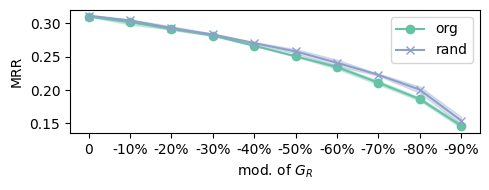

slurm_multitask_fb15k-237 org
slurm_multitask_fb15k-237 rand


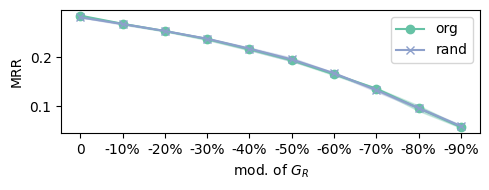

In [38]:
def vis_rel_feature_abl(model_name):
    run_name = f'slurm_{model_name}_fb15k-237'
    x = ['0', '-10%', '-20%', '-30%', '-40%', '-50%', '-60%', '-70%', '-80%', '-90%']

    def get_mean_std_ablation(run_name, t='org'):
        print(run_name, t)
        mrr = []
        for i in range(1,4):
            mrr.append([result_files[f'{run_name}_{t}.txt'][0]['MRR']] + [result['MRR'] for result in [result_files[f'{run_name}_{t}_{i}_{percent}.txt'][0] for percent in ['10', '20', '30', '40', '50', '60', '70', '80', '90']]])

        mrr = np.array(mrr)
        mean = np.mean(mrr, axis=0)
        std = np.std(mrr, axis=0)
        return mean, std


    mrr_mean_org, mrr_std_org = get_mean_std_ablation(run_name, t='org')
    mrr_mean_rand, mrr_std_rand = get_mean_std_ablation(run_name, t='rand')

    plt.figure(figsize=(5,2))
    plt.plot(x, mrr_mean_org, '-o', color=color_a)
    plt.plot(x, mrr_mean_rand, '-x', color=color_b)

    plt.fill_between(x, mrr_mean_org-mrr_std_org, mrr_mean_org+mrr_std_org, alpha=0.3, color=color_a)
    plt.fill_between(x, mrr_mean_rand-mrr_std_rand, mrr_mean_rand+mrr_std_rand, alpha=0.3, color=color_b)

    plt.ylabel('MRR')
    plt.xlabel('mod. of $G_R$')

    plt.legend(['org', 'rand'])

    plt.tight_layout()
    plt.savefig(osp.join(TEX_PATH, f'rel_abl_{model_name}_fig.pdf'))
    plt.show()

vis_rel_feature_abl('literaledistmult')
vis_rel_feature_abl('multitask')

# Tables

### Numerical feature ablation: original literal feature vs. random features -> org_vs_rand_tab.tex

In [40]:
out_file = open(osp.join(TEX_PATH, 'org_vs_rand_tab.tex'), 'w')

head = """
\\begin{table}[]
\setlength{\\tabcolsep}{6pt}
\\renewcommand{\\arraystretch}{1.1}

\caption{Numerical feature ablation: original literal feature vs. random features}
\\label{tab:org_vs_rand}
\\begin{center}
\\begin{tabular}{l|rll|rll}

\hline
      & \multicolumn{3}{c|}{\\textbf{original features}} & \multicolumn{3}{c}{\\textbf{random features}} \\\\
\\textbf{model}      & \\textbf{MR} & \\textbf{MRR} & \\textbf{Hits@1} & \\textbf{MR}  & \\textbf{MRR} & \\textbf{Hits@1} \\\\ \hline
"""

tail = """
\hline
\end{tabular}
\end{center}
\end{table}
"""

out_file.write(head + '\n')

for dataset in ['fb15k-237', 'yago3-10', 'litwd48k']:
    out_file.write(f'\hline \multicolumn{{7}}{{c}}{{\\textbf{{{dataset_2_name[dataset]}}}}} \\\\ \\hline \n')
    for model in model_2_name.keys():
        line_string = model_2_name[model]
        for feature_type in ['org', 'rand']:
            for metric in ['MR', 'MRR', 'Hits@1']:
                if metric == 'MR':
                    mean = f'{np.mean([result[metric] for result in result_files[f"slurm_{model}_{dataset}_{feature_type}.txt"]]):.0f}'
                    std = f'{np.std([result[metric] for result in result_files[f"slurm_{model}_{dataset}_{feature_type}.txt"]]):.0f}'.zfill(3)
                else:
                    mean = f'{np.mean([result[metric] for result in result_files[f"slurm_{model}_{dataset}_{feature_type}.txt"]]):.3f}'[1:]
                    std = f'{np.std([result[metric] for result in result_files[f"slurm_{model}_{dataset}_{feature_type}.txt"]]):.3f}'[1:]
                line_string += f'& ${mean}{{\scriptstyle \pm {std}}}$ '
        #print(line_string)
        out_file.write(line_string + ' \\\\ \n')

out_file.write(tail)
out_file.close()

### Feature Variations -> feat_var_tab.tex

In [41]:
out_file = open(osp.join(TEX_PATH, 'variations_tab.tex'), 'w')

head = """
\\begin{table}[]
\setlength{\\tabcolsep}{6pt}
\\renewcommand{\\arraystretch}{1.1}

\caption{Comparison of different features derived from the original numerical features for FB15k-237. The model that uses the literals provided with the dataset is named \textit{original}. For completeness, we also report the scores of the DistMult model without the LiteralE extension to incorporate literals.}
\\label{tab:variations}
\\begin{center}

\\begin{tabular}{l|lllll}
\hline
\multicolumn{1}{l|}{\\textbf{features}} & \\textbf{MR} & \\textbf{MRR} & \\textbf{Hits@1} & \\textbf{Hits@3} & \\textbf{Hits@10} \\\\
"""


tail = """
\hline
\end{tabular}
\end{center}
\end{table}
"""

feature_variante_2_label = {
    'org': 'original',
    'rand': 'random',
    'attr': 'relation type',
    'filtered-100': 'filtered',
    'base-model': 'base model'
}


out_file.write(head)

for model in ['kbln', 'literalecomplex']:
    out_file.write(f'\hline \multicolumn{{6}}{{c}}{{\\textbf{{{model_2_name[model]}}}}} \\\\ \hline \n')

    for feature_variante in ['org', 'rand', 'attr', 'base-model']:
        if feature_variante != 'base-model':
            file_name = f'slurm_{model}_fb15k-237_{feature_variante}.txt'
        else:
            if model == 'literalecomplex':
                file_name = 'slurm_complex_fb15k-237.txt'
            else:
                continue

        line_string = f'{feature_variante_2_label[feature_variante]} '

        for metric in ['MR', 'MRR', 'Hits@1', 'Hits@3', 'Hits@10']:
            if metric == 'MR':
                mean = f'{np.mean([result[metric] for result in result_files[file_name]]):.0f}'
                std = f'{np.std([result[metric] for result in result_files[file_name]]):.0f}'.zfill(3)
            else:
                mean = f'{np.mean([result[metric] for result in result_files[file_name]]):.3f}'[1:]
                std = f'{np.std([result[metric] for result in result_files[file_name]]):.3f}'[1:]
            line_string += f'& ${mean}{{\scriptstyle \pm {std}}}$ '
        out_file.write(line_string + '\\\\ \n')

    if model == 'literalecomplex':
        print(result_files['slurm_complex_fb15k-237.txt'])

out_file.write(tail)
out_file.close()

[{'MRR': 0.2886858149000476, 'MR': 630.0, 'Hits@10': 0.4467128537735849, 'Hits@3': 0.31876474056603776, 'Hits@1': 0.20781741352201258}, {'MRR': 0.2891358812140634, 'MR': 645.0, 'Hits@10': 0.447376179245283, 'Hits@3': 0.31844536163522014, 'Hits@1': 0.2099056603773585}, {'MRR': 0.2901997989313443, 'MR': 644.0, 'Hits@10': 0.45012775157232704, 'Hits@3': 0.3213689072327044, 'Hits@1': 0.2091686320754717}]


### Dataset statistics

Entities without numerical literals

In [44]:
for dataset in ['FB15k-237', 'YAGO3-10', 'LitWD48K', 'Synthetic']:
    entities_relational_triples = set()
    for split in ['train', 'valid', 'test']:
        with open(osp.join(DATA_PATH, f'{dataset.lower()}/{split}.txt'), 'r') as f:
            lines = f.readlines()

            for line in lines:
                head, rel, tail = line.strip().split('\t')
                entities_relational_triples.add(head)
                entities_relational_triples.add(tail)

    entities_attributive_triples = set()
    m = '_decimal' if dataset == 'LitWD48K' else ''
    with open(osp.join(DATA_PATH, f'{dataset}/literals/numerical_literals{m}.txt'), 'r') as f:
        lines = f.readlines()
        for line in lines:
            entity, attr, value = line.strip().split('\t')
            entities_attributive_triples.add(entity)
    print(dataset, ':', len(entities_relational_triples) - len(entities_attributive_triples))


FB15k-237 : 4600
YAGO3-10 : 31030
LitWD48K : 8198
Synthetic : 38
